# Trace Analysis 

This notebook performs some analysis on the trace files for the initial consensus experiments. 

In [3]:
%matplotlib inline

import os
import re
import csv
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
## Load Data 

PROPRE = re.compile(r'^trace-(\d+)ms-(\d+)user.tsv$')
TRACES = os.path.join("..", "fixtures", "traces", "trace-*")

def load_trace_data(traces=TRACES, pattern=PROPRE):
    for idx, name in enumerate(glob.glob(traces)):
        path = os.path.abspath(name)
        name = os.path.basename(name)
        prop = dict(zip(('access mean (ms)', 'users'), map(int, pattern.match(name).groups())))
        prop['id'] = idx + 1
        
        with open(path, 'r') as f:
            tstep = 0
            header = ('time', 'replica', 'object', 'access')
            reader = csv.DictReader(f, delimiter='\t', fieldnames=header)
            
            for row in reader:
                row.update(prop)
                row['time']  = int(row['time'])
                row['delay since last access (ms)'] = row['time'] - tstep 
                tstep = row['time']
                yield row

traces = pd.DataFrame(load_trace_data())

## Trace Visualization

In [ ]:
sns.factorplot(
    data=traces, x="replica", y="delay since last access (ms)", hue="access", 
    row='access mean (ms)', col='users', kind='bar'
)

In [ ]:
sns.factorplot(
    data=traces, x="object", y="delay since last access (ms)", hue="replica", 
    row='access mean (ms)', col='users', kind='bar'
)

In [ ]:
def count(x):
    return sum(1 for i in x)

repobj = traces.groupby(['replica', 'object', 'access mean (ms)', 'users', 'access'])
repobj = repobj.agg({'delay since last access (ms)': np.mean, 'id': count, 'time': np.sum})

del repobj['time']
repobj = repobj.rename(columns = {'id':'count'})

In [ ]:
sns.clustermap(repobj)

In [ ]:
sns.factorplot(
    data=traces, x="time", y="object",
    row='access mean (ms)', col='users', kind='violin'
)

## Experiment Analysis 

Some details on the experimental design from the JSON files. 

In [ ]:
## Load Data

TOPORE = re.compile(r'^(\w+)\-(\d+).json$')
TOPOLOGIES = os.path.join("..", "fixtures", "experiments", "*.json")

def load_experiment_data(topos=TOPOLOGIES, pattern=TOPORE):
    for name in glob.glob(topos):
        path = os.path.abspath(name)
        name = os.path.basename(name)
        prop = dict(zip(('type', 'id'), pattern.match(name).groups()))
        prop['eid'] = int(prop['id']) 
        
        with open(path, 'r') as f:
            data  = json.load(f)
            conns = {
                link['source']: link['latency']
                for link in data['links']
            }
            conns.update({
                link['target']: link['latency']
                for link in data['links']
            })
            
            for idx, node in enumerate(data['nodes']):
                node.update(prop)
                node['users'] = data['meta']['users']
                latency = conns[idx]
                electto = node.pop('election_timeout', [0,0])
                del node['consistency']
                
                node['eto_low']  = electto[0]
                node['eto_high'] = electto[1]
                node['eto_mean'] = sum(electto) / 2.0
                node['latency_low']  = latency[0]
                node['latency_high'] = latency[1]
                node['latency_mean'] = sum(latency) / 2.0
                
                yield node 

experiments = pd.DataFrame(load_experiment_data())

In [ ]:
experiments.describe()

In [ ]:
sns.factorplot(x='eid', y='latency_mean', kind='bar', row='type', hue='users', data=experiments)

## Tiered Trace Analysis 

Visualizations of the trace access patterns for confirmation. 

In [4]:
data = pd.read_csv('../fixtures/traces/tiered.tsv', sep='\t', names=['time', 'replica', 'object', 'access'])

In [5]:
aggregation = {
    'time': {
        'from': 'min', 
        'to': 'max'
    },
    'access': {
        'count'
    }
}

replicas = data.groupby(['replica', 'object']).agg({'access': 'count'})

In [6]:
from collections import defaultdict
records = defaultdict(dict)
for replica, obj, count in replicas.to_records():
    records[replica][obj] = count 

records = pd.DataFrame(records)
# records = records.fillna(0)

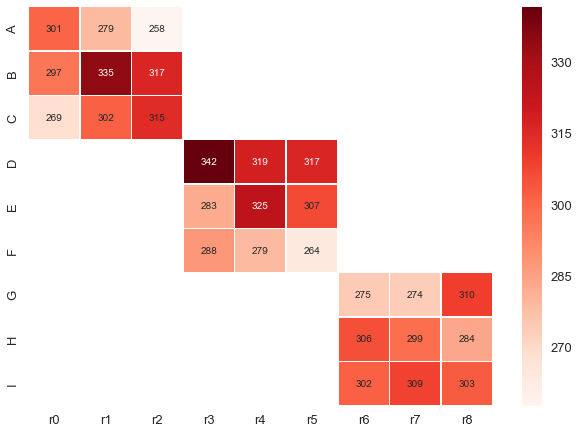

In [7]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.heatmap(records, annot=True, fmt="0.0f", linewidths=.5, cmap="Reds")

In [27]:
series = defaultdict(list)
for idx, ts, rep, obj, acc in data.to_records():
    series[obj].append((ts, acc))

durations = defaultdict(list)
    
for obj, times in series.iteritems():
    prev = 0 
    for time, acc in times:
        durations[obj].append((time - prev, acc))
        prev = time 

data = []
for key, duration in durations.iteritems():
    for time, acc in duration:
        data.append((key, time, acc))

In [31]:
df = pd.DataFrame(data)
df.columns = ['object', 'since', 'access']

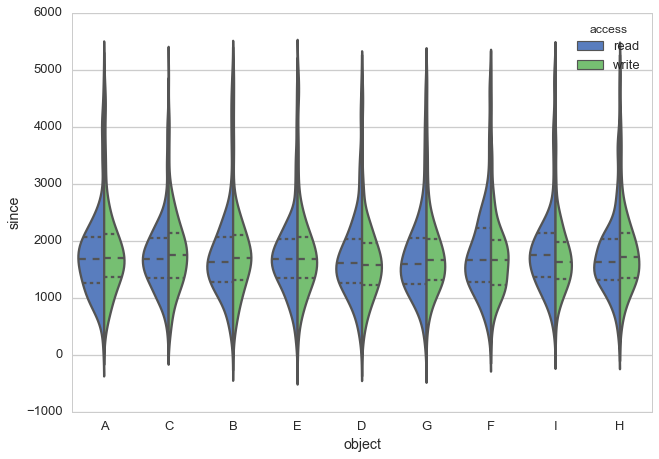

In [39]:
sns.violinplot(x="object", y="since", hue="access", data=df[df.since < 5000], palette="muted", split=True,  scale="count", inner="quartile")